## Import Libraries

In [ ]:
#Admin and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Access
import os
path = ('/content/drive/My Drive/AC420/GroupProj')
os.chdir(path)
df = pd.read_csv('projdata.csv')

## Clean dataset

In [ ]:
#Clean
df = df.replace(r'^\s*$', 0, regex=True)
pd.set_option('display.max_columns', 20)

# Fast-Food Industry Overview

The analysis focuses on the fast-food sector.  
In 2020, the market size was USD 862B and is expected to grow at a CAGR of 6.05%, reaching USD $1,467B by 2028.  
Post-COVID-19 shifts in consumer behavior have fueled the growth of convenience dining, as more families prefer having meals delivered directly to their homes.

There are 52 unique companies
The average number of companies in the sample is 47.0
Number of companies are NOT more or less stable over time
This could be because of the number of M&A, companies going private
And because of the number of companies being listed


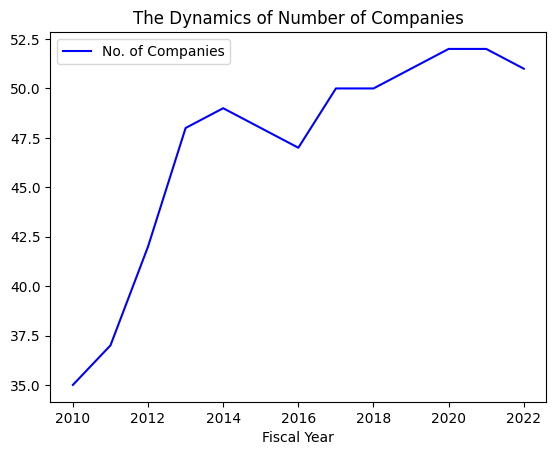

In [ ]:
#Using Porter's 5:
# - Supplier Power is low, larger companies own parts of supply chain, and smaller companies have many alternatives
# - Buyer Power is high, many substitutes to choose from
# - Threat of Substitution is low, nothing beats the gloriously unhealthy snacks
# - Threats of Entry are low, hard to start a franchise that is competitive
# - Competitive Rivalry is high, existing brands have established moats and economies of scale

#Requirement 2.2.2
df = df[df['fyear'] >= 2010]
df2 = df['conm'].groupby(df.fyear).describe()

print("There are", df2['unique'].max(), "unique companies")
print("The average number of companies in the sample is", df2['unique'].mean().round(0))

#reset index
df2 = pd.pivot_table(df2, values= 'unique', index = ['fyear']).reset_index()

x = df2['fyear']
y = df2['unique']
plt.plot(x, y, label = 'No. of Companies', color = 'blue')

plt.title('The Dynamics of Number of Companies')
plt.xlabel('Fiscal Year')
plt.legend();

print('Number of companies are NOT more or less stable over time')
print('This could be because of the number of M&A, companies going private')
print('And because of the number of companies being listed')
#print('Group has decided to take only the companies that had the full set of data')

Filtered to include only companies with 13+ observations and plotted the number of companies over time, which remains fully stable.

There are 28 unique companies
The average number of companies in the sample is 28.0
Number of companies is 100% stable over time
This is because we have filtered by the companies that appear 13 times


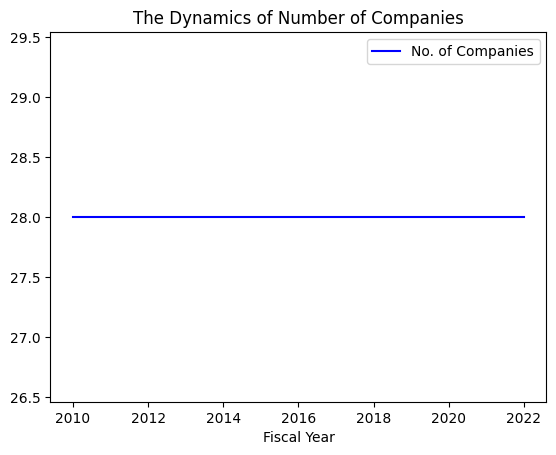

In [ ]:
#Filter to have it only have all the values (Balanced panel)
dfx = df.groupby('conm').filter(lambda x: len(x) >= 13)

df2 = dfx['conm'].groupby(dfx.fyear).describe()

print("There are", df2['unique'].max(), "unique companies")
print("The average number of companies in the sample is", df2['unique'].mean().round(0))

#reset index
df2 = pd.pivot_table(df2, values= 'unique', index = ['fyear']).reset_index()

x = df2['fyear']
y = df2['unique']
plt.plot(x, y, label = 'No. of Companies', color = 'blue')

plt.title('The Dynamics of Number of Companies')
plt.xlabel('Fiscal Year')
plt.legend();

print('Number of companies is 100% stable over time')
print('This is because we have filtered by the companies that appear 13 times')

## Total Assets Analysis

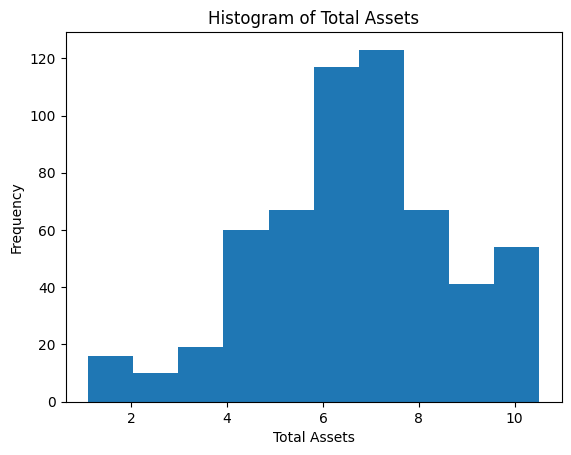

count    574.000000
mean       6.642522
std        2.005031
min        1.103268
25%        5.482083
50%        6.735730
75%        7.878862
max       10.508522
Name: win_log_at, dtype: float64
MCDONALD'S CORP
STARBUCKS CORP
REBORN COFFEE INC
YOSHIHARU GLOBAL CO
WENDY'S CO
YUM BRANDS INC


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
<ipython-input-18-e9c4e7a38a71>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df21['abs_diff'] = abs(df21['at'] - mean)


In [ ]:
#Requirement 2.2.3
df = df.dropna(subset = ['at'])
df = df[df['at'] >= 1] #remove values under 1
df['log_at'] = np.log(df['at'])
df['win_log_at'] = winsorize(df['log_at'], limits=[0.01, 0.01])
plt.hist(df['win_log_at'], bins=10)
plt.xlabel('Total Assets')
plt.ylabel('Frequency')
plt.title('Histogram of Total Assets')
plt.show()

print(df['win_log_at'].describe())
#Observed that mean < median
#The distribution is negatively skewed
#Distinct kurtosis observed on both ends, with tail data on both the
#larger and smaller sides of the scale

#Identify 2 largest, 2 smallest and 2 closest to mean size companies for 2021
df21 = df[df['fyear'] == 2021]

#Largest
largest = df21.sort_values('at', ascending=False)['conm'].iloc[0]
largest2 = df21.sort_values('at', ascending=False)['conm'].iloc[1]
print(largest)
print(largest2)

#Smallest
smallest = df21.sort_values('at', ascending=True)['conm'].iloc[0]
smallest2 = df21.sort_values('at', ascending=True)['conm'].iloc[1]
print(smallest)
print(smallest2)

#Mean
mean = df21['at'].mean()
df21['abs_diff'] = abs(df21['at'] - mean)
means = df21.nsmallest(2, 'abs_diff')['conm'].tolist()
print(means[0])
print(means[1])

# Stock Return Calculation
Filtered December stock prices for the first three days of each year, computed daily returns, and calculated the average annual return per ticker.

In [ ]:
#Requirement 2.4.1
print(dfx['tic'].unique())

#Requirement 2.4.2
dfy = pd.read_csv('crispy.csv')
dfy['date'] = pd.to_datetime(dfy['date'], format='%Y-%m-%d')
dfy = dfy[(dfy['date'].dt.month == 12) & ((dfy['date'].dt.day == 1) | (dfy['date'].dt.day == 2) | (dfy['date'].dt.day == 3))]
dfy = dfy.groupby(['TICKER', dfy['date'].dt.year]).first()
dfy

#Let's Roll:
dfy['RET'] = dfy.groupby('TICKER')['PRC'].apply(lambda x: (x - x.shift(1))/x.shift(1))

avgret = dfy.groupby('TICKER')['RET'].mean()
dfy2 = pd.DataFrame({'TICKER': avgret.index, 'Avg RET': avgret.values})
dfy2 #toggle to see list

['EAT' 'BH' 'CBRL' 'WEN' 'BDL' 'MCD' 'ARKR' 'JACK' 'MHGU' 'DENN' 'GTIM'
 'SBUX' 'CAKE' 'PZZA' 'BJRI' 'YUM' 'SDXAY' 'RRGB' 'DPZ' 'TXRH' 'RUTH'
 'QSR' 'CMG' 'BLMN' 'TAST' 'ARCO' 'CHUY' 'FRGI']


<ipython-input-19-81d2bdf416b7>:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  dfy['RET'] = dfy.groupby('TICKER')['PRC'].apply(lambda x: (x - x.shift(1))/x.shift(1))


,TICKER,Avg RET
0,ARCO,-0.018912
1,ARKR,-0.304971
2,BDL,-0.108215
3,BH,0.093926
4,BJRI,0.025271
5,BLMN,0.057886
6,CAKE,0.019795
7,CBRL,0.091541
8,CHUY,0.071665
9,CMG,0.229794


#Annual Stock Return Analysis  
Calculated and plotted the average and median annual stock returns since 2011, highlighting a significant increase in 2013 due to low interest rates affecting the broader market

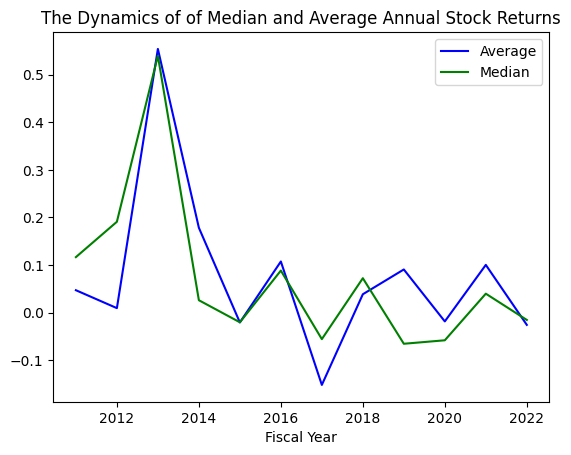

In [ ]:
#Requirement 2.4.3
dfy3 = dfy.groupby(dfy['date'].dt.year)['RET']
avgret = dfy3.mean().reset_index()
medret = dfy3.median().reset_index()
dfy3 = pd.DataFrame({'Year': avgret['date'], 'Avg RET': avgret['RET'], 'Med RET': medret['RET']})
dfy3 = dfy3[dfy3['Year'] >= 2011]
dfy3

x = dfy3['Year']
y1 = dfy3['Avg RET']
y2 = dfy3['Med RET']

plt.plot(x, y1, label = 'Average', color = 'blue')
plt.plot(x, y2, label = 'Median', color = 'green')

plt.title('The Dynamics of of Median and Average Annual Stock Returns')
plt.xlabel( 'Fiscal Year')
plt.legend();

#Significant change in 2013:

#Jeremy Glaser, a markets editor at Morningstar, says one big reason stocks
#did so well was that interest rates stayed low.
#And when interest rates are low, stocks benefit.
#Source: npr.org/2013/12/31/258699463/2013-was-a-tremendous-year-at-least-for-the-stock-market

#Macro trend across all stocks, not specifically sector-specific

In [ ]:
#Requirement 2.4.4
from pandas.io.parsers.readers import IndexLabel
dfz = dfy[dfy['date'].dt.year == 2020]
dfz = dfz.sort_values(by="RET", ascending=False)
dfz = dfz.droplevel(1) #Since it's a multi-index, I'll drop the year
dfz = dfz.reset_index()
print('The company with the largest annual stock return was', dfz.TICKER[0],
      'with a return of', dfz.RET[0].round(2))
print('The company with the smallest annual stock return was', dfz.TICKER.iloc[-1],
      'with a return of', dfz.RET.iloc[-1].round(2))

#https://www.forbes.com/sites/greatspeculations/2021/11/24/more-room-for-gains-in-chipotles-stock/?sh=7e3540564e14
#Mostly driven by digital sales during COVID, despite lockdowns
#Focus on app development so that ordering is streamlined and easy
#Shifting consumer preference towards digital sales
#Gross Profit Margin at 17.4%, comparable to 2017 onwards

#https://seekingalpha.com/article/4517592-dennys-stock-early-signs-turnaround-but-issues-remain
#Management decision to divest locations, considered to not be a good move
#Limited upside on potential covid recovery was priced-in
#(eg if reopening plays out, they don't get as much revenues)
#Overall macro issue of COVID damping dine-in F&B revenues
#Revenues shrunk and GP margin at 35.1%, lowest in history

The company with the largest annual stock return was CMG with a return of 0.62
The company with the smallest annual stock return was DENN with a return of -0.4


In [ ]:
#Requirement 2.4.5
#Just the same code from above, but for 2018
dfz = dfy[dfy['date'].dt.year == 2018]
dfz = dfz.sort_values(by="RET", ascending=False)
dfz = dfz.droplevel(1) #Since it's a multi-index, I'll drop the year
dfz = dfz.reset_index()
print('The company with the largest annual stock return was', dfz.TICKER[0],
      'with a return of', dfz.RET[0].round(2))
#https://seekingalpha.com/article/4167754-biglari-holdings-2018-annual-meeting-notes
#Not so much BH doing well as BH "recovering" from the previous year's dismal
#performance, they gained up to 50% above 2016's numbers before declining
#again in 2019 to just about 20-30% above 2016. See table below.
#According to their Annual Report, Steak n Shake reported a USD$10M loss.
#Management comments that Henry Ford's lower price, higher volume — we
#failed to implement his highly efficient assembly line methods. To be a market leader in the fast food
#business, we should have paid greater heed to becoming, well, fast. We are in the process of
#addressing this misstep.
dfy[44:48]

The company with the largest annual stock return was BH with a return of 1.1


PERMNO       date     CUSIP     PRC       RET
TICKER date                                               
BH     2016   26607 2016-12-01  08986R30  464.00  0.260870
       2017   26607 2017-12-01  08986R30  337.78 -0.272026
       2018   17677 2018-12-03  08986R40  710.00  1.101960
       2019   17677 2019-12-02  08986R40  565.00 -0.204225

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/data_table.py", line 187, in _repr_mimebundle_
    dataframe = self._preprocess_dataframe()
  File "/usr/local/lib/python3.10/dist-packages/google/colab/data_table.py", line 175, in _preprocess_dataframe
    dataframe = dataframe.reset_index()
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 331, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 6361, in reset_index
    new_obj.insert(
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 4817, in insert
    raise ValueError(f"cannot insert {column}, already exists")
ValueError: cannot insert date, already exists
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/data_table.py", line 199, in _repr_javascript_module_
    return self._gen_js(self._preprocess_dataframe())
  Fil

In [ ]:
#Requirement 2.5
#Let's Roll:
f_roll = lambda x: x.rolling(2).mean()
dfx['log_at'] = np.log(dfx['at'])
dfx['avg_ceq'] = dfx.groupby('tic', group_keys=False).ceq.apply(f_roll)
dfx['avg_asset'] = dfx.groupby('tic', group_keys=False).at.apply(f_roll)
dfx['leverage'] = dfx.groupby('tic', group_keys=False).ceq.apply(f_roll)
dfx['roa'] = (dfx.ni/dfx.avg_asset)
dfn = pd.merge(dfy, dfx, left_on=['TICKER', dfy.index.get_level_values('date')],
               right_on=['tic', 'fyear'], how='inner')
dfn = dfn[['RET', 'leverage', 'roa', 'log_at']]
dfn = dfn.dropna(subset=['RET'])

xlist = [dfn['leverage'], dfn['roa'], dfn['log_at']]
Y = dfn['RET']

for X in xlist:
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X)
    print_model = model.summary()
    #print(print_model) #toggle to see results
    #print("******************************************************************************")

Coefficient for Leverage was positive and negative for ROA/logAT. Indicates that higher leverage could result in higher annual stock returns, but the reverse is true for ROA/logAT (which doesn't make sense), but if there is, the impact is very small.

However, upon looking at the R-squared and adj R, all are less than 0.07, which indicates that the regression model does not explain the observed data well (i.e. there is not a good fit)

T and P values suggest that there is some statistical significance to the result

# Binary Return Regression  
Converted returns to a binary variable, ran OLS regressions with leverage, ROA, and log assets, and found all coefficients positive and significant, with ROA explaining ~10% of variance.

In [ ]:
#Requirement 2.5.2
#Using the binary, in case the 2.5 wasn't enough
dfn['RETB'] = np.where(dfn['RET'] > 0, 1, 0)

#Just the same as above
xlist = [dfn['leverage'], dfn['roa'], dfn['log_at']]
Y = dfn['RETB'] #except for here

for X in xlist:
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X)
    print_model = model.summary()
    #print(print_model) #toggle to see results
    #print("******************************************************************************")


## Regression Insights

Now it is clearer that the coefficient is 0.5 for Leverage, 0.4 for ROA and 0.3 for log_at.

All with positive magnitude which indicates that higher x var results in higher y var on avg implies that higher var results in positive annual returnson average.

All p-values are low, indicating that it is statistically significant.

Only R-Squared and adj R for ROA is >0.1, meaning that only ROA explains 10% of the variation in the data, and the others explain very little.
Must look at other factors.